# 1. 라이브러리 import

In [1]:
!pip install transformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.5/7.5 MB 16.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 18.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 17.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 16.8 MB/s eta 0:00:00


In [2]:
import torch
import transformers
from transformers import AutoModelWithLMHead, PreTrainedTokenizerFast
from fastai.text.all import *
import re
import fastai

print(torch.__version__)
print(transformers.__version__)
print( fastai.__version__)

2.0.1+cu118
4.32.0
2.7.12


# 2. Fine-tuning 전 kogpt2

In [3]:
tokenizer = PreTrainedTokenizerFast.from_pretrained("skt/kogpt2-base-v2",
  bos_token='</s>', eos_token='</s>', unk_token='<unk>',
  pad_token='<pad>', mask_token='<mask>')
model = AutoModelWithLMHead.from_pretrained("skt/kogpt2-base-v2")
text = """2030에게 2년적금을 연이율 5%로 8월1일부터 31일까지 인스타그램으로 홍보 """
input_ids = tokenizer.encode(text)
gen_ids = model.generate(torch.tensor([input_ids]),
                           max_length=128,
                           repetition_penalty=2.0,
                           pad_token_id=tokenizer.pad_token_id,
                           eos_token_id=tokenizer.eos_token_id,
                           bos_token_id=tokenizer.bos_token_id,
                           use_cache=True
                        )
generated = tokenizer.decode(gen_ids[0,:].tolist())
print(generated)

The tokenizer class you load from this checkpoint is not the same type as the class this function is called from. It may result in unexpected tokenization. 
The tokenizer class you load from this checkpoint is 'GPT2Tokenizer'. 
The class this function is called from is 'PreTrainedTokenizerFast'.
/usr/local/lib/python3.10/dist-packages/transformers/models/auto/modeling_auto.py:1468: FutureWarning: The class `AutoModelWithLMHead` is deprecated and will be removed in a future version. Please use `AutoModelForCausalLM` for causal language models, `AutoModelForMaskedLM` for masked language models and `AutoModelForSeq2SeqLM` for encoder-decoder models.
  warnings.warn(


2030에게 2년적금을 연이율 5%로 8월1일부터 31일까지 인스타그램으로 홍보 #인생템
<unk>sunny_official</d> 오늘은 제가 좋아하는 과자랑 빵을 먹으러 갔는데요.
빵집이라서 그런지 사람들이 많이 몰려있더라구요
그래도 저는 그냥 먹고싶어서 간거였어요!
저는 이번에 먹은게 젤 맛있어서
먹고 싶었는데 너무너무 좋았어요.
그리고 또 다른건 바로 딸기잼인데요,
딸기쨈에 딸기가 들어있는것 같아용!ᄏᄒᄉᄋ~^^ 
아


# 3. 데이터 전처리

In [7]:
import os
import re

with open('preprocessed_text.txt', 'r', encoding='utf-8') as f:
    data = f.read()
data=" ".join(data.split())
# print(len(data))
data = data.replace('\n|\t', ' ')
print(len(data))
# new_sent = data.replace(" ", '') # 띄어쓰기가 없는 문장 임의로 만들기
# # print(len(new_sent))
# spacing = Spacing()
# kospacing_sent = spacing(new_sent)
# print(len(kospacing_sent))
data = re.sub('[-=+,#/\:^$@*\"※~&%ㆍ』\\‘|\(\)\[\]\<\>`\'…》]','', data)
print(len(data))
data = re.sub('[a-zA-Z]' , '', data)
print(len(data))
data = re.sub(r'[0-9]+' , '', data)
print(len(data))
# UnicodeDecodeError: 'cp949' codec can't decode byte 0xec in position 20: illegal multibyte sequence
# 해당 에러 ->  encoding='utf-8' 넣어 주기

92499
92499
84854
79893


In [9]:
# Open a text file in write mode
with open('kr_lyrics_20_preprocess.txt', 'w', encoding='utf-8') as file:
    # Write the string to the file
    file.write(data)

# 4. 데이터 로드 & Tokenize

In [4]:
with open('preprocessed_text.txt', 'r', encoding='utf-8') as f:
    data = f.read()

#model input output tokenizer
class TransformersTokenizer(Transform):
   def __init__(self, tokenizer): self.tokenizer = tokenizer
   def encodes(self, x):
       toks = self.tokenizer.tokenize(x)
       return tensor(self.tokenizer.convert_tokens_to_ids(toks))
   def decodes(self, x): return TitledStr(self.tokenizer.decode(x.cpu().numpy()))

#split data
train=data[:int(len(data)*0.9)]
test=data[int(len(data)*0.9):]
splits = [[0],[1]]

#init dataloader
tls = TfmdLists([train,test], TransformersTokenizer(tokenizer), splits=splits, dl_type=LMDataLoader)
dls = tls.dataloaders(bs=4, seq_len=128)

# 5. 모델 훈련

SuggestedLRs(valley=6.30957365501672e-05)


epoch,train_loss,valid_loss,perplexity,time
0,4.254623,4.260063,70.814423,00:24
1,3.819081,4.125662,61.908772,00:22
2,3.415302,4.062861,58.140411,00:23
3,2.987814,4.051164,57.464287,00:23
4,2.548244,4.110822,60.996849,00:22
5,2.127003,4.211937,67.487129,00:23
6,1.747591,4.426006,83.596848,00:25
7,1.408603,4.617644,101.255173,00:24
8,1.133496,4.808027,122.489677,00:22
9,0.900261,4.966851,143.574097,00:24


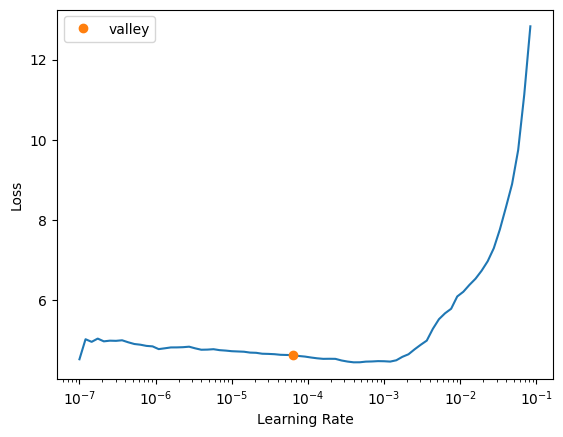

In [5]:
#gpt2 ouput is tuple, we need just one val
class DropOutput(Callback):
  def after_pred(self): self.learn.pred = self.pred[0]


learn = Learner(dls, model, loss_func=CrossEntropyLossFlat(),
cbs=[DropOutput], metrics=Perplexity()).to_fp16()

lr=learn.lr_find()
print(lr)
learn.fit_one_cycle(50, lr)

# 6. Fine-tuning 결과

In [6]:
prompt=" 2030에게 2년적금을 연이율 5%로 8월1일부터 31일까지 인스타그램으로 홍보 "
prompt_ids = tokenizer.encode(prompt)
inp = tensor(prompt_ids)[None].cuda()
preds = learn.model.generate(inp,
                           max_length=128,
                           pad_token_id=tokenizer.pad_token_id,
                           eos_token_id=tokenizer.eos_token_id,
                           bos_token_id=tokenizer.bos_token_id,
                           repetition_penalty=2.0,
                           use_cache=True
                          )
tokenizer.decode(preds[0].cpu().numpy())

'2030에게 2년적금을 연이율 5%로 8월1일부터 31일까지 인스타그램으로 홍보  참여방법하나금융그룹hanafnofficial 팔로우 필수본 게시물 리필 링크 클릭2 본 이벤트 페이지에서 하나은행 로고 찾아 인증샷을 올려주세요3 스타벅스 아메리카노 100명 추첨 발표EVENT 봉사활동 나눔 ESG\n대전하프타임 댄스챌린지 3차2114화_주인공은떠오르는 영 플레이어울산현대의 히어로 OO 선수공격수로서 갖춰야 할재능 하나가 알려줄'

# 7. 모델 저장

In [7]:
learn.model.save_pretrained("./models/kogpt2_backup_50")

In [8]:
!zip -r models.zip /content/models/

NotImplementedError: ignored